<a href="https://colab.research.google.com/github/Alenush/dish_id_sirius/blob/Team-1/chefnet_dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузка данных

In [2]:
!pip install gdown

### Загрузка картинок

In [3]:
!gdown https://drive.google.com/uc?id=1Usn-XgKql3aUAQcbt5S4-BEM7Zg8Jgwq
!unzip -qq AllRecipes_images.zip
!rm AllRecipes_images.zip

Downloading...
From: https://drive.google.com/uc?id=1Usn-XgKql3aUAQcbt5S4-BEM7Zg8Jgwq
To: /content/AllRecipes_images.zip
4.02GB [00:38, 103MB/s] 


In [ ]:
import os
print(f"Train amount - {len(os.listdir('AllRecipes_images/train'))}")
print(f"Val amount - {len(os.listdir('AllRecipes_images/val'))}")

Train amount - 162547
Val amount - 40648


### Загрузка ингредиентов блюд

In [4]:
!gdown https://drive.google.com/uc?id=1vc2OT7zAGlcbMi25Or2JUWLevES238aS
!gdown https://drive.google.com/uc?id=11gUIVJrOmdc0edYF9eHT11DrhYFnuxM2
!gdown https://drive.google.com/uc?id=1Oj-tq8L0mU34kjIo7DWjG9uxeXZPMrkP

Downloading...
From: https://drive.google.com/uc?id=1vc2OT7zAGlcbMi25Or2JUWLevES238aS
To: /content/recipes_raw.json
12.0MB [00:00, 56.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=11gUIVJrOmdc0edYF9eHT11DrhYFnuxM2
To: /content/clean_ingred.txt
100% 1.44k/1.44k [00:00<00:00, 2.37MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oj-tq8L0mU34kjIo7DWjG9uxeXZPMrkP
To: /content/rus_clean_ingred.txt
100% 2.88k/2.88k [00:00<00:00, 4.58MB/s]


## Обучение

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import numpy as np
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
with open('recipes.json', 'rb') as f:
  recipe_list = json.loads(f.read())
with open('clean_ingred.txt', 'r') as f:
  clean_ingredients = list(f.read().split('\n'))

In [3]:
en2ru = {}
with open('clean_ingred.txt', 'r') as f:
  en=f.readlines()
with open('rus_clean_ingred.txt', 'r') as f:
  ru=f.readlines()

for e, r in zip(en, ru):
  en2ru[e.rstrip('\n')] = r.rstrip('\n')
with open('en2ru_ing.json', 'w') as f:
  json.dump(en2ru, f)

In [4]:
id2word = defaultdict()
for i, ingr in enumerate(clean_ingredients):
  id2word[i+1] = ingr

word2id = {v:k for k,v in id2word.items()}
def words2ids(ingreds):
  return [word2id[ing] for ing in ingreds]

In [6]:
class RecipesDataset(Dataset):
  def __init__(self, recipes_json, img_folder, transform=None):
    super().__init__()

    with open(recipes_json, 'r') as f:
      recipes = json.load(f)
    self.recipes = defaultdict(dict)
    for recipe in recipes:
      self.recipes[recipe['id']] = recipe

    self.img_folder = img_folder
    self.imgs = os.listdir(self.img_folder)
    self.imgs = [img for img in self.imgs if img.split('_')[0] in self.recipes]
    
    self.transform = transform

  def __getitem__(self, index):
    img_name = self.imgs[index]
    img = Image.open(self.img_folder + img_name).convert('RGB')
    if self.transform is not None:
      img = self.transform(img)
    
    recipe_id = img_name.split('_')[0]
    ingred_list = self.recipes[recipe_id]['ingred_list']
    return img, torch.LongTensor(words2ids(ingred_list))

  def __len__(self):
    return len(self.imgs)

In [7]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(data):
  # отсортируем по длине описания
  data.sort(key=lambda x: len(x[1]), reverse=True)
  images, captions = zip(*data)
  
  # составим 4D тензор изображений из кортежа 3D тензоров
  # images: (batch_size, channels(rgb), width, height)
  images = torch.stack(images, 0)
  
  # составим 2D тензор описаний из кортежа 1D тензоров
  # дополним каждое описание символом <pad> так, чтобы у всех описаний совпадали длины
  targets = pad_sequence(captions, batch_first=True, padding_value=0)

  return images, targets

In [8]:
#!pip install googletrans
from random import randint
from googletrans import Translator
translator = Translator()

val_images = os.listdir('AllRecipes_images/val')

def predict_val_image():
  with torch.no_grad():
    img_name = val_images[randint(0, len(val_images)-1)]
    recipe_id = img_name.split('_')[0]
    img = Image.open(os.path.join('AllRecipes_images/val', img_name))
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = transform_val(img).to(device).unsqueeze(0)
    ingred_pred = model(img) > 0.25
    ingred_pred = ingred_pred.nonzero()[:, 1].tolist()
    ingred_pred = [id2word[ing+1] for ing in ingred_pred]
    ingred_pred = [en2ru[ing] for ing in ingred_pred]
    
    dish_name = train_data.recipes[recipe_id]['item_name']
    #dish_name = translator.translate(dish_name, src='en', dest='ru').text
    ingred_real = train_data.recipes[recipe_id]['ingred_list']
    ingred_real = [en2ru[ing] for ing in ingred_real]
    print(dish_name + ':', end='\n\n')
    print('Real:')
    print('\t' + '\n\t'.join(ingred_real), end='\n\n')
    print('Prediction:')
    print('\t' + '\n\t'.join(ingred_pred))

In [9]:
def predict_image(path_to_img, transform):
  with torch.no_grad():
    img = Image.open(path_to_img).convert('RGB')
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = transform(img).to(device).unsqueeze(0)
    ingred_pred = [id2word[ing+1] for ing in ingred_pred]
    ingred_pred = [en2ru[ing] for ing in ingred_pred]
    print('\t' + '\n\t'.join(ingred_pred))

In [10]:
def update_error_types(error_types, y_pred, y_true):
  y_pred, y_true = y_pred.cpu().numpy(), y_true.cpu().numpy()

  error_types['tp_all'] += (y_pred * y_true).sum()
  error_types['fp_all'] += (y_pred * (1-y_true)).sum()
  error_types['fn_all'] += ((1-y_pred) * y_true).sum()

In [11]:
import torch.nn.functional as F
def label2onehot(labels):
    # input labels to one hot vector
    return F.one_hot(labels, num_classes=len(word2id)+1).sum(1)[:, 1:]

def compute_metrics(error_types, eps=1e-10, weights=None):
  result = defaultdict(float)
  result['jaccard'] = error_types['tp_all'] / (error_types['tp_all'] + error_types['fp_all'] + error_types['fn_all'] + eps)

  pre = error_types['tp_all'] / (error_types['tp_all'] + error_types['fp_all'] + eps)
  result['pre'] = pre
  rec = error_types['tp_all'] / (error_types['tp_all'] + error_types['fn_all'] + eps)
  result['rec'] = rec
  f1 = 2 * (pre * rec) / (pre + rec + eps)
  result['f1'] = f1
  return result

In [12]:
def train(model, criterion, optimizer, scheduler, num_epochs,
          epoch_losses, start_epoch, save_path):
 
  for epoch in range(start_epoch, num_epochs + start_epoch):
    # режим обучения
    model.train()

    running_loss = 0.0
    print(f'Эпоха {epoch}/{start_epoch + num_epochs - 1}')
    for images, tokens in tqdm(train_loader, desc=f'Обучение {epoch}'):
      # Перенесем изобр-я и описания на GPU, составим вектор истинных описаний
      images = images.to(device)
      real = label2onehot(tokens).to(device).float()

      # Проведем изобр-я через модель, получим описания (в виде векторов id), сгенерир. моделью
      pred = model(images)

      # посчитать лосс на батче
      loss = criterion(pred, real)
      
      # посчитать градиенты
      loss.backward()
      
      # обновить параметры модели
      optimizer.step()
      
      # обнулить градиенты
      optimizer.zero_grad()

      running_loss += loss.item()


    train_loss = running_loss / len(train_loader)
    scheduler.step(train_loss)
    epoch_losses['train_nll'].append(train_loss)

    torch.save(model.state_dict(), f'/content/drive/My Drive/Dish-id/model_densenet/epoch_{epoch}.pth')

    with open(f'{save_path}/epoch_losses.pkl', 'wb') as f:
      pickle.dump(epoch_losses, f)

    # Validation
    error_types = {'tp_all': 0, 'fp_all': 0, 'fn_all': 0}
    model.eval()
    for images, tokens in tqdm(val_loader, desc=f'Валидация'):
      images = images.to(device)
      real = label2onehot(tokens).to(device)

      pred = model(images) > 0.25
      update_error_types(error_types, real, pred)

    val_metrics = compute_metrics(error_types)
    
    predict_val_image()

    print(f'Train loss:\t{train_loss:.4f}')
    print(f'Val metrics:\n\t', end='')
    for k, v in val_metrics.items():
      print(f'{k}: {np.mean(v):.4f}', end=', ')
      epoch_losses[k].append(np.mean(v))
    print('\n')

In [13]:
transform_train = transforms.Compose([
  transforms.RandomResizedCrop((224, 224)),
  transforms.RandomHorizontalFlip(0.5),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

train_data = RecipesDataset('recipes.json', 'AllRecipes_images/train/', transform_train)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=True)

In [14]:
transform_val = transforms.Compose([
  transforms.Resize((250, 250)),
  transforms.CenterCrop((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_data = RecipesDataset('recipes.json', 'AllRecipes_images/val/', transform_val)

batch_size = 128
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=False)

Модель

In [15]:
model = models.densenet161(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
num_feat = model.classifier.in_features
model.classifier = nn.Sequential(
        nn.Linear(num_feat, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, len(word2id)),
        nn.Sigmoid()
    )
model.to(device)
epoch_losses = defaultdict(list)
for param in model.features.denseblock4.parameters():
  param.requires_grad = True
for param in model.features.transition3.parameters():
  param.requires_grad = True
for param in model.features.denseblock3.parameters():
  param.requires_grad = True
for param in model.features.transition2.parameters():
  param.requires_grad = True

In [16]:
criterion = nn.BCELoss(reduction='mean')
torch.manual_seed(42)
optimizer = optim.Adam(params=model.classifier.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True, min_lr=1e-5)

In [ ]:
epoch_losses = defaultdict(list)
for param in model.features.denseblock4.parameters():
  param.requires_grad = True
for param in model.features.transition3.parameters():
  param.requires_grad = True
for param in model.features.denseblock3.parameters():
  param.requires_grad = True
for param in model.features.transition2.parameters():
  param.requires_grad = True

torch.backends.cudnn.benchmark = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
train(model, criterion, optimizer, scheduler, num_epochs=5, epoch_losses=epoch_losses, 
      start_epoch=1, save_path='/content/drive/My Drive/Dish-id/model_densenet')

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
train(model, criterion, optimizer, scheduler, num_epochs=10, epoch_losses=epoch_losses, 
      start_epoch=6, save_path='/content/drive/My Drive/Dish-id/model_densenet')

In [23]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=True)
batch_size = 32
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          num_workers=4, collate_fn=pad_collate, shuffle=False)

Эпоха 12/15


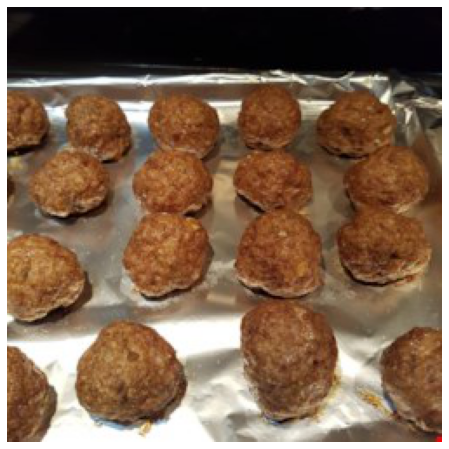

Tasty Baked Meatballs:

Real:
	грибы
	сыр
	лук
	говядина
	яйцо
	хлеб

Prediction:
	мука
	молоко
	лук
	корица
	хлеб
	яйцо
	сливочное масло
	сахар
	масло
Train loss:	0.0836
Val metrics:
	jaccard: 0.3270, pre: 0.5319, rec: 0.4591, f1: 0.4928, 

Эпоха 13/15



Epoch    13: reducing learning rate of group 0 to 1.0000e-04.


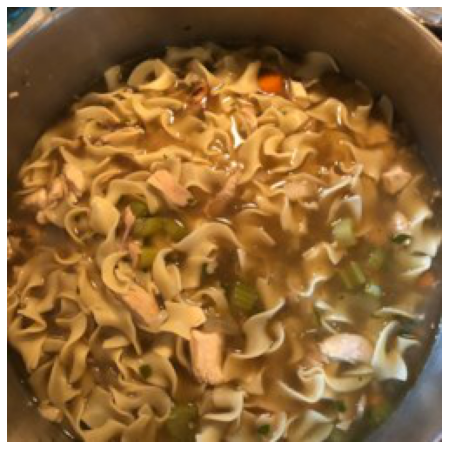

Grandma's Chicken Noodle Soup:

Real:
	сельдерей
	лапша
	масло
	лук
	вода
	курица
	домашняя птица

Prediction:
	курица
	капуста
	лук
	лапша
	сельдерей
	вода
	лук-порей
	морковь
Train loss:	0.0819
Val metrics:
	jaccard: 0.3342, pre: 0.5405, rec: 0.4669, f1: 0.5010, 

Эпоха 14/15


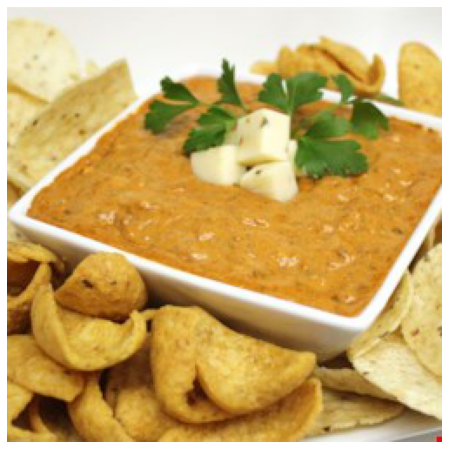

Man Dip:

Real:
	сыр
	сливочный сыр

Prediction:
	фасоль
	лук
	помидор
	масло
	имбирь
Train loss:	0.0807
Val metrics:
	jaccard: 0.3364, pre: 0.5497, rec: 0.4643, f1: 0.5034, 

Эпоха 15/15



Epoch    15: reducing learning rate of group 0 to 1.0000e-05.


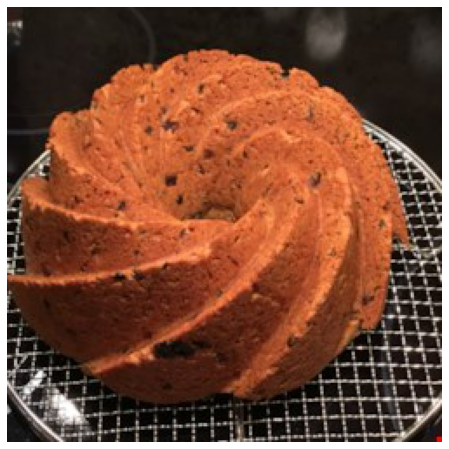

Mincemeat Quick Bread:

Real:
	сахар
	сок
	масло
	мука
	апельсин
	разрыхлитель
	яйцо
	пищевая сода

Prediction:
	мука
	молоко
	разрыхлитель
	ваниль
	яйцо
	сливочное масло
	сахар
	вода
	какао
	сметана
	масло
	пищевая сода
Train loss:	0.0797
Val metrics:
	jaccard: 0.3379, pre: 0.5443, rec: 0.4712, f1: 0.5051, 



In [24]:
for param in model.features.denseblock2.parameters():
  param.requires_grad = True
for param in model.features.transition1.parameters():
  param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
train(model, criterion, optimizer, scheduler, num_epochs=4, epoch_losses=epoch_losses, 
      start_epoch=12, save_path='/content/drive/My Drive/Dish-id/model_densenet')

In [ ]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
train(model, criterion, optimizer, scheduler, num_epochs=5, epoch_losses=epoch_losses, 
      start_epoch=16, save_path='/content/drive/My Drive/Dish-id/model_densenet')

Эпоха 21/25


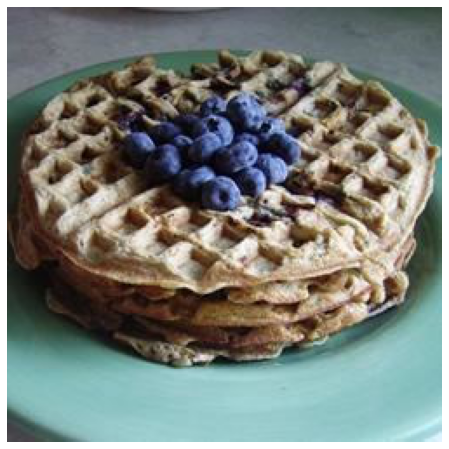

Blueberry Flavored Waffles:

Real:
	сахар
	черника
	сливочное масло
	кефир
	мука
	яйцо
	пищевая сода
	йогурт

Prediction:
	мука
	молоко
	разрыхлитель
	ваниль
	яйцо
	сливочное масло
	сахар
	пищевая сода
Train loss:	0.0722
Val metrics:
	jaccard: 0.3676, pre: 0.5910, rec: 0.4930, f1: 0.5376, 

Эпоха 22/25


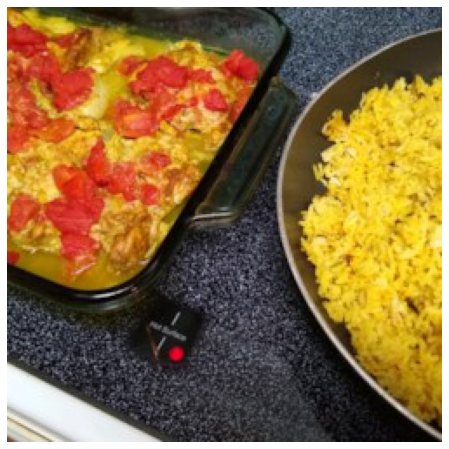

Biryani with Yogurt Marinated Chicken:

Real:
	йогурт
	масло
	лук
	вода
	курица
	соус
	кардамон
	корица
	имбирь
	помидор
	рис

Prediction:
	курица
	лук
	сыр
	помидор
	рис
	масло
	болгарский перец
Train loss:	0.0711
Val metrics:
	jaccard: 0.3685, pre: 0.5949, rec: 0.4919, f1: 0.5385, 

Эпоха 23/25


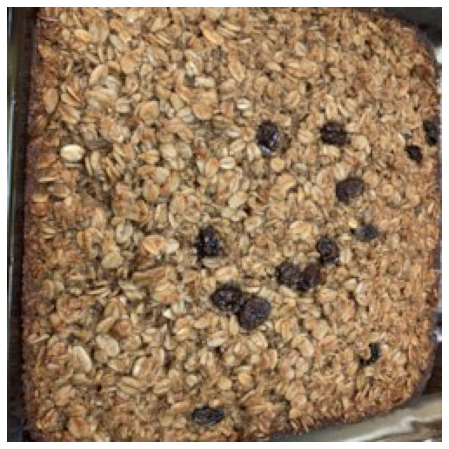

Baked Oatmeal:

Real:
	сахар
	сироп
	овсяные хлопья
	молоко
	ваниль
	сливочное масло
	клюква
	разрыхлитель
	корица
	яйцо

Prediction:
	миндаль
	мед
	ваниль
	корица
	сливочное масло
	сахар
	овсяные хлопья
	сироп
	масло
	изюм
	кокос
Train loss:	0.0704
Val metrics:
	jaccard: 0.3694, pre: 0.5970, rec: 0.4920, f1: 0.5395, 

Эпоха 24/25


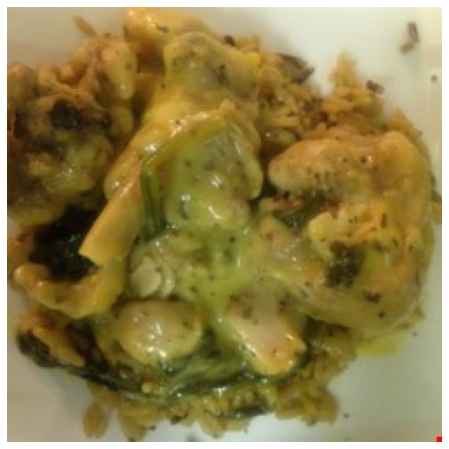

Simple Creamy Lemon Chicken Sauce:

Real:
	вода
	сливочное масло
	сок
	курица

Prediction:
	курица
	мука
	лук
	сыр
	грибы
	сливочное масло
	масло
Train loss:	0.0700
Val metrics:
	jaccard: 0.3688, pre: 0.5968, rec: 0.4912, f1: 0.5389, 

Эпоха 25/25


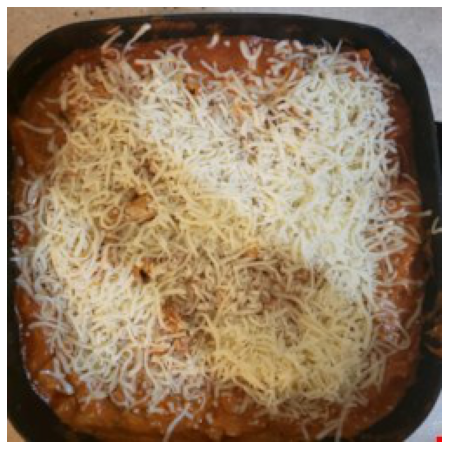

Easy Cheesy Skillet Lasagna:

Real:
	грибы
	сыр
	красный перец
	масло
	лук
	вода
	соус
	колбаса
	лазанья

Prediction:
	говядина
	лук
	сыр
	помидор
	яйцо
	сахар
	соус
	масло
Train loss:	0.0698
Val metrics:
	jaccard: 0.3695, pre: 0.5969, rec: 0.4924, f1: 0.5396, 



In [28]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
train(model, criterion, optimizer, scheduler, num_epochs=5, epoch_losses=epoch_losses, 
      start_epoch=21, save_path='/content/drive/My Drive/Dish-id/model_densenet')

Graphs

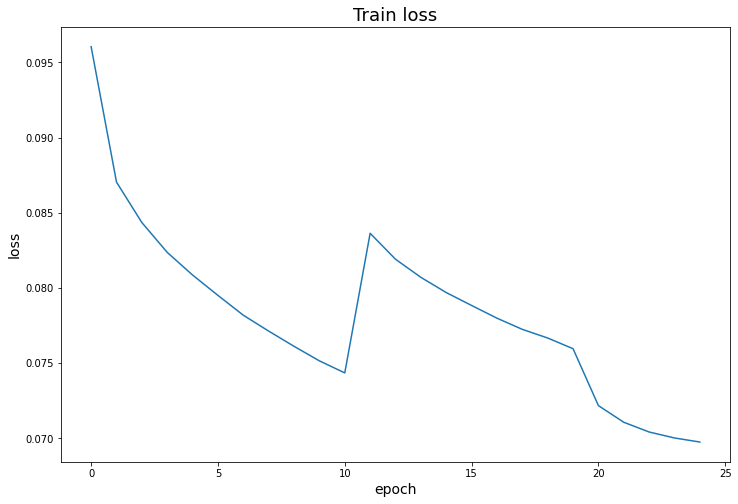

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(epoch_losses['train_nll'])
plt.title('Train loss', fontsize=18)
plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.show()

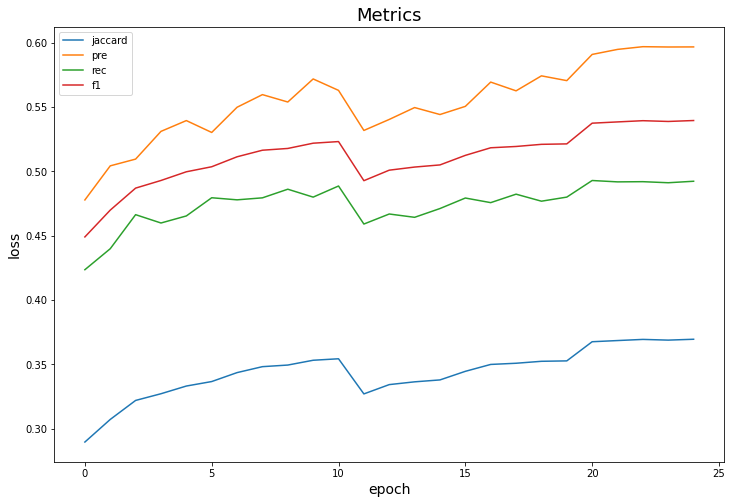

In [30]:
plt.figure(figsize=(12, 8))
plt.title('Metrics', fontsize=18)
for k in epoch_losses:
  if k=='train_nll':
    continue
  plt.plot(epoch_losses[k], label=k)

plt.ylabel('loss', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.legend()
plt.yscale('linear')
plt.show()